In [2]:
import numpy as np
import pennylane as qml
from pennylane import expval, var, device
pi = np.pi

In [3]:
name ='LiH';charge = 0;multiplicity=1;basis= 'sto-3g';geometry = 'lih.xyz';
h, nr_qubits = qml.qchem.generate_hamiltonian(
    name,
    geometry,
    charge,
    multiplicity,
    basis,
    mapping='jordan_wigner',
    n_active_orbitals=2,
    n_active_electrons=2,
)
print(nr_qubits)

4


In [6]:
@qml.template
def R(theta, phi, wires):
    """Decompose the R(theta, phi) operation.
    R(theta, phi) = Rz(phi+pi).Ry(theta+pi/2)
                  = Rz(pi).Rz(phi).RY(theta).{{1, -1}, {1, 1}}/sqrt(2)
    """
    H = np.array([[1, -1], [1, 1]])/np.sqrt(2)
    qml.QubitUnitary(H, wires=wires[0])
    qml.RY(theta, wires=wires[0])
    qml.RZ(phi, wires=wires[0])

class A(qml.operation.Operation):
    num_params = 2
    num_wires = 2
    par_domain = "R"
    grad_method = "A"

    @staticmethod
    @qml.template
    def decomposition(theta, phi, wires):
        """Perform the A gate decomposition from the paper"""
        qml.CNOT(wires=[wires[1], wires[0]])
        qml.inv(R(theta, phi, wires=[wires[1]]))
        qml.CNOT(wires=[wires[0], wires[1]])
        R(theta, phi, wires=[wires[1]])
        qml.CNOT(wires=[wires[1], wires[0]])


In [7]:
dev = qml.device("default.qubit", wires=4)

In [12]:
def circuit(params,wires=[0,1,2,3]):
    qml.PauliX(wires=wires[1])
    qml.PauliX(wires=wires[2])

    A(params[0],params[1], wires=[wires[0],wires[1]])
    A(params[2],params[1], wires=[wires[2],wires[3]])
    A(params[3],params[1], wires=[wires[1],wires[2]])

    A(params[4],params[5], wires=[wires[0],wires[1]])
    A(params[6],params[7], wires=[wires[2],wires[3]])
    A(params[8],params[9], wires=[wires[1],wires[2]])

In [27]:
initial_params = np.random.uniform(low=0, high=2*np.pi, size=10)

In [28]:
qnodes = qml.map(circuit, h.ops, dev, measure='expval')
cost = qml.dot([h.coeffs], qnodes)

In [29]:
cost(initial_params)

array([-7.67028738])

In [30]:
fb_metric = qnodes[0].metric_tensor([initial_params])
print(fb_metric)

[[ 2.50000000e-01 -4.97880932e-18  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.97880932e-18  2.15274983e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.50000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.50000000e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.37490694e-01  0.00000000e+00  0.00000000e+00 -3.04318342e-03
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.50000000e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

In [31]:
max_iter = 200
step_size = 0.05
conv_tol = 1e-6

energycost = []
params = initial_params

for n in range(max_iter):
    gradient = qml.grad(cost, argnum=[0])
    grad_at_point = [float(i) for i in gradient(params)[0]]
    
    params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), grad_at_point)
    
    energy = cost(params)
    energycost.append(energy)
    conv = abs(energy - prev_energy)
    
    prev_energy = energy
    
    
    if conv <= conv_tol:
        print('found ground-state at step {:}'.format(n))
        print("Groud-state energy = ", energy)
        break
    if n % 20 == 0:
        print('step = {:} \n energy = {:} \n convergence = {:} ha'.format(n, energy, conv))
    
    

step = 0 
 energy = [-7.6806214] 
 convergence = [0.07833155] ha
step = 20 
 energy = [-7.75742028] 
 convergence = [0.00116847] ha
step = 40 
 energy = [-7.76600925] 
 convergence = [0.00011748] ha
step = 60 
 energy = [-7.76690869] 
 convergence = [1.39242548e-05] ha
step = 80 
 energy = [-7.76703706] 
 convergence = [3.12574422e-06] ha
step = 100 
 energy = [-7.76708153] 
 convergence = [1.77013817e-06] ha
step = 120 
 energy = [-7.76711279] 
 convergence = [1.41952595e-06] ha
step = 140 
 energy = [-7.76713887] 
 convergence = [1.2096882e-06] ha
step = 160 
 energy = [-7.76716128] 
 convergence = [1.04477285e-06] ha
found ground-state at step 167
Groud-state energy =  [-7.76716839]


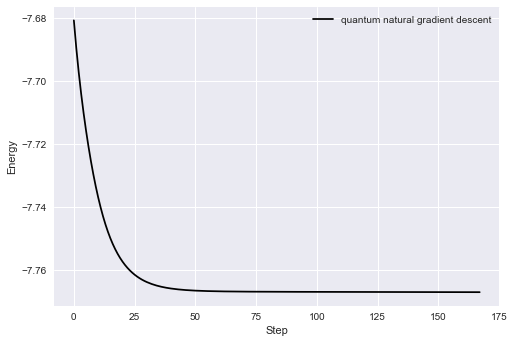

In [32]:
from matplotlib import pyplot as plt
plt.style.use("seaborn")
plt.plot(energycost, "black", label="quantum natural gradient descent")

plt.ylabel("Energy")
plt.xlabel("Step")
plt.legend()
plt.show()